In [120]:
######### MODULES ##########
import sys, os, re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from PIL import Image
from scipy import interpolate as spinter, ndimage as spimg, signal as spsig, optimize as spopt
from delta_method import delta_method, parametric_bootstrap
plt.rcParams.update({'font.size':14})
np.set_printoptions(threshold=sys.maxsize)

In [121]:
a = [1,2,3,4]
b = [5,4,3,2]

def func(c, *d):
    print(c)
    print(d)

polynomial(a, *b)

array([ 14,  41,  98, 197])

In [122]:
###########SHINY NEW FUNCTIONS###############

def cubic(x, a, b, c, d):
    y = a + b*x + c*x**2 + d*x**3
    return y

def quartic(x, a, b, c, d, e):
    y = a + b*x + c*x**2 + d*x**3 + e*x**4
    return y

def quintic(x, a, b, c, d, e, f):
    y = a + b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5
    return y

def polynomial(x, *coeffs):
    x = np.array(x)
    y = np.sum([coeff*x**n for n, coeff in enumerate(coeffs)], axis= 0)
    return y

def flatten_2d_list(bookshelf):
    return [page for book in bookshelf for page in book]

def flatten_3d_list(library): #Would be nice to know the number of dimentions of a list. This is not easy. :( I can only use np.arrays if the list is 'rectangular'.
    return [page for bookshelf in library for book in bookshelf for page in book]

def roll_average(xs, ys, window_width, number_of_points= 100):
    xs = flatten_3d_list(xs)
    ys = flatten_3d_list(ys)

    points = np.linspace(np.nanmin(xs), np.nanmax(xs), number_of_points)
    average = []
    uncertainty = []
    
    for point in points:
        points_in_window = [ys[n] for n, x in enumerate(xs) if x-window_width < point and point < x+window_width] #create a list of points inside the window
        average = average + [np.nanmean(points_in_window)]
        uncertainty = uncertainty + [np.nanstd(points_in_window)]

    return points, average, uncertainty

def spline_interpolation(xs, ys, number_of_points= 100, smoothing= 1):
    xs, ys = flatten_3d_list(xs), flatten_3d_list(ys)
    is_valid = np.logical_and(~np.isnan(xs), ~np.isnan(ys))
    xs, ys = np.array(xs)[is_valid], np.array(ys)[is_valid] #remove nans
    [xs, ys], counts = np.unique([xs, ys], return_counts= True, axis=1) #remove duplicates
    ascending_x = np.argsort(xs)
    xs, ys, counts = xs[ascending_x], ys[ascending_x], counts[ascending_x] #sort
    counts = counts /np.sum(counts) #normalise

    points = np.linspace(0, 1, num=number_of_points)

    spline, _ = spinter.splprep([xs,ys], w=counts, s= smoothing) # FORTRAN routine B)
    interpolated_points = spinter.splev(points, spline)

    return interpolated_points[0], interpolated_points[1]

def polynomial_fit(xs, ys, number_of_points= 100, x0= [1, -0.13, 0.2, -0.09, 0], confidence= 0.1):
    xs, ys = flatten_3d_list(xs), flatten_3d_list(ys)
    is_valid = np.logical_and(~np.isnan(xs), ~np.isnan(ys))
    xs, ys = np.array(xs)[is_valid], np.array(ys)[is_valid] #remove nans

    points = np.linspace(np.nanmin(xs), np.nanmax(xs), number_of_points)

    popt, pcov = spopt.curve_fit(polynomial, xs, ys, p0= x0, nan_policy= "omit", method= "trf", loss= "cauchy") # loss = "linear" for least squares. "huber" "soft_l1" "cauchy" "arctan"
    delta = delta_method(pcov, popt, points, polynomial, xs, ys, confidence)

    poly_fit = polynomial(points, *popt)

    return points, poly_fit, delta


def read_metadata(requested_data): #NOT IDIOT PROOF. BE CAREFUL WHEN USING
    shot_list = ["SHOT #","Date","Time","Purpose","Target X","Target Y","Target Z","Wheel XPS","position on wheel","TARGET NUMBER","Laser Energy (before comp) [J]","Laser duration [fs]","Horiz ns/div","Trigger val [mV]","C1 [V/div]","C2 [V/div]","C3 [V/div]","C4 [V/div]","C1 att [dB]","C2 att [dB]","C3 att [dB]","C1 diag","C2 diag","C3 diag","C4 diag","Comments JLD scope","THz comments","Column2","X-ray comments","Column3","Column4","Column5"]
    target_list = ["Date","Number","Position in the box","Wheel","Position on the wheel","Rotation angle(TARGET)","XYZ (TARGET)","Thickness (um)","Length(mm)","Material","Type","Comments"]

    if requested_data[0] in shot_list : sheet, header_row = "Shot-list", 1 # weird python syntax
    if requested_data[0] in target_list : sheet, header_row = "Target list", 0

    dataframe = pd.read_excel(io= "organised_data\\Shots_Targets_Diagnostics.xlsx", # numpy is bad at reading excel files.
                              sheet_name= sheet,
                              header= header_row,
                              usecols= requested_data)
    
    dictionary = dataframe.to_dict(orient= "list")
    #dictionary = {key: np.array(dataframe[key]) for key in dataframe.columns} # pandas doesn't have a `dataframe.to_dict(orient= "array")`

    return dictionary

def open_pyro_oscilloscope(requested_data, shots, file_directories, file_names, silent= True):
    channel = "Ch1" if requested_data == "pyro_time" else requested_data
    regex_code = ".*SHOT("+'|'.join(shots)+")[^0-9]*[0-9]{3}[^0-9].*"+channel+".csv"
    match = [bool(re.findall(regex_code, file_name)) for file_name in file_names]
    filtered_file_directories = file_directories[match]
    filtered_file_names = file_names[match]
    number_of_files = len(filtered_file_names)
    filtered_file_paths = [os.path.join(filtered_file_directories[n],filtered_file_names[n]) for n in range(number_of_files)]
                            
    shot_no = [int(re.search(regex_code, filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
    pyro_data = [np.genfromtxt(filtered_file_path, delimiter=',', skip_header =0, usecols= 3 if requested_data == "pyro_time" else 4) for filtered_file_path in filtered_file_paths]

    if not silent: # remember to do silent == True if you use read_data in a loop
        print("Found {:d} files:".format(len(filtered_file_names)))
        [print("   " + filtered_file_name) for filtered_file_name in filtered_file_names]

    return shot_no, pyro_data

def open_emp_oscilloscope(requested_data, shots, file_directories, file_names, silent= True):
    emp_oscilloscope_data = ["time","bdot","tof","diode"]
    column = emp_oscilloscope_data.index(requested_data)
    regex_code = "(?i)s0*("+'|'.join(shots)+")[^0-9]*\.csv"
    match = [bool(re.findall(regex_code, file_name)) for file_name in file_names]
    filtered_file_directories = file_directories[match]
    filtered_file_names = file_names[match]
    number_of_files = len(filtered_file_names)
    filtered_file_paths = [os.path.join(filtered_file_directories[n],filtered_file_names[n]) for n in range(number_of_files)]

    shot_no = [int(re.search(regex_code, filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
    emp_data = [np.genfromtxt(filtered_file_path, delimiter=',', skip_header =18, usecols= column) for filtered_file_path in filtered_file_paths]

    if not silent: # remember to do silent == True if you use read_data in a loop
        print("Found {:d} files:".format(len(filtered_file_names)))
        [print("   " + filtered_file_name) for filtered_file_name in filtered_file_names]

    return shot_no, emp_data

def read_diagnostic_data(requested_data, silent= False):
    data_path = "organised_data\\"
    dictionary = {"shot":[]}
    emp_oscilloscope_data = ["time","bdot","tof","diode"]
    pyro_oscilloscope_data = ["Ch1","Ch2","Ch3","Ch4","pyro_time"]

    all_file_directories = [root for root, dirs, files in os.walk(data_path) for file in files]
    all_file_directories = np.array(all_file_directories)
    all_file_names = [file for root, dirs, files in os.walk(data_path) for file in files]
    all_file_names = np.array(all_file_names)
    requested_data = {ch: [str(int(shot)) for shot in shots] for ch, shots in requested_data.items()} # ensure that all shot numbers are strings of ints. floats will screw up re.

    for request, shots in requested_data.items():
        if request in pyro_oscilloscope_data:
            new_shots, new_data = open_pyro_oscilloscope(request, shots, all_file_directories, all_file_names, silent= silent)
        elif request in emp_oscilloscope_data:
            new_shots, new_data = open_emp_oscilloscope(request, shots, all_file_directories, all_file_names, silent= silent)
        else:
            new_shots, new_data = [], []
            print("WARNING!! {0} is not a recognised data type.".format(request))

        old_shots = dictionary["shot"]
        union_shots = np.unique(old_shots + new_shots).tolist()

        dictionary = {diagnostic: [readings[old_shots.index(shot)] if shot in old_shots else np.nan for shot in union_shots] for diagnostic, readings in dictionary.items()} #rearrange the existing data to corrispond with its respective shot
        dictionary[request] = [new_data[new_shots.index(shot)] if shot in new_shots else np.nan for shot in union_shots] # List comprehention gives me headaches. Add the new data to it's respective shot. pandas might be better for this.
        dictionary["shot"] = union_shots #add the new shots

    return dictionary

In [123]:
shotsheet = read_metadata(["SHOT #","Target X","Target Z","TARGET NUMBER","Laser Energy (before comp) [J]"])
targetsheet = read_metadata(["Number","Wheel"])

total_number_of_shots = len(shotsheet["SHOT #"])

for key in shotsheet.keys():
    shotsheet[key] = [np.nan if re.search('[^\d.]', str(value)) else float(value) for value in shotsheet[key]] # Filter out all numberic characters. Numeric characters being: `0123456789.`

shotsheet["Wheel"] = [targetsheet["Wheel"][targetsheet["Number"].index(target_number)] if target_number in targetsheet["Number"] else np.nan for target_number in shotsheet["TARGET NUMBER"]] # give each target it's respective wheel. 

In [124]:
 ###Initialisation
target = 0
shotsheet["relative X"] = np.full(len(shotsheet["SHOT #"]), fill_value= np.nan)
shotsheet["relative Z"] = np.full(len(shotsheet["SHOT #"]), fill_value= np.nan)
###Loop over all shots
for n in range(total_number_of_shots):
    if shotsheet["TARGET NUMBER"][n] != target:
        delta_x = shotsheet["Target X"][n]
        delta_z = shotsheet["Target Z"][n]
        target = shotsheet["TARGET NUMBER"][n] # ASSUMES THAT WE DON'T RETURN BACK TO THE SAME TARGET.

    shotsheet["relative X"][n] = shotsheet["Target X"][n] -delta_x
    shotsheet["relative Z"][n] = shotsheet["Target Z"][n] -delta_z

shotsheet["d"] = np.linalg.norm([shotsheet["relative X"], shotsheet["relative Z"]], axis= 0) # pythagorus to find d. This might be a little simplistic since we know the angle should be 25°

pd.DataFrame(shotsheet)

,SHOT #,Target X,Target Z,TARGET NUMBER,Laser Energy (before comp) [J],Wheel,relative X,relative Z,d
0,1.0,NaN,NaN,1.0,1.700,1.0,NaN,NaN,NaN
1,2.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
2,3.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
3,4.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
4,5.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
262,262.0,3.845,5.65,125.0,0.866,7.0,1.5,0.75,1.677051
263,263.0,4.445,5.97,125.0,0.859,7.0,2.1,1.07,2.356884
264,264.0,5.045,6.32,125.0,0.794,7.0,2.7,1.42,3.050639
265,265.0,5.745,6.72,125.0,0.824,7.0,3.4,1.82,3.856475


In [125]:
targets = {"Ch2": [105,106],
           "Ch3": [66,67,69,90,105,106],
           "Ch4": [66,67,69,86]}
emp = {"Ch1": [90,105,106,108],
       "Ch2": [66,67,69,81,86]}
oscilloscope = {"bdot": [66,67,69,86,90,105,106]}

emp_lookup = {t: ch for ch, target in emp.items() for t in target} #Create a target -> channel lookup table.
emp_lookup = {shotsheet["SHOT #"][n]: ch for n in range(total_number_of_shots) for t, ch in emp_lookup.items() if shotsheet["TARGET NUMBER"][n] == t} #Convert to a shot -> channel lookup table.
emp = {ch: [shotsheet["SHOT #"][n] for t in target for n in range(total_number_of_shots) if shotsheet["TARGET NUMBER"][n] == t] for ch, target in {**emp, **oscilloscope}.items()} #find the respective shots for these targets. Include both pyro emp and osc emp data mearly to ensure that has the same indexes as the next dictionary
shots = {ch: [shotsheet["SHOT #"][n] for t in target for n in range(total_number_of_shots) if shotsheet["TARGET NUMBER"][n] == t] for ch, target in {**targets, **oscilloscope}.items()} #find the respective shots for these targets. Include both the target and emp data

pyro_emp = read_diagnostic_data(emp, silent= True)
pyro = read_diagnostic_data(shots, silent= True)

In [126]:
pyro = {key: [
             np.subtract( # Background subtract
                pyro[key][pyro["shot"].index(shot)], # signal on channel `key`
                pyro_emp[emp_lookup[shot]][pyro_emp["shot"].index(shot)]) # EMP background on channel `emp_lookup[shot]`
             for shot in pyro["shot"] # for every shot
             ]
             if key in targets.keys() else pyro[key] # only pyroelectric channels should be subject to background subtraction
             for key in pyro.keys()} # for every channel

In [127]:
pyro = {key: [np.abs(np.nanmin(shot)) for shot in pyro[key]] if key != "shot" else pyro["shot"] for key in pyro.keys()} #find the minima of every shot

for key in pyro.keys():
    if key != "shot":
        shotsheet[key] = [pyro[key][pyro["shot"].index(shot)] if shot in pyro["shot"] else np.nan for shot in shotsheet["SHOT #"]] #add channel minima to the shotsheet on respective shot numbers

#shotsheet = {key: np.array(shotsheet[key]) for key in shotsheet.keys()} #make all shotsheet dict values into arrays.

pd.DataFrame(shotsheet)

C:\Users\syf83691\AppData\Local\Temp\ipykernel_12688\3507058854.py:1: RuntimeWarning: All-NaN slice encountered
  pyro = {key: [np.abs(np.nanmin(shot)) for shot in pyro[key]] if key != "shot" else pyro["shot"] for key in pyro.keys()} #find the minima of every shot
C:\Users\syf83691\AppData\Local\Temp\ipykernel_12688\3507058854.py:1: RuntimeWarning: All-NaN axis encountered
  pyro = {key: [np.abs(np.nanmin(shot)) for shot in pyro[key]] if key != "shot" else pyro["shot"] for key in pyro.keys()} #find the minima of every shot


,SHOT #,Target X,Target Z,TARGET NUMBER,Laser Energy (before comp) [J],Wheel,relative X,relative Z,d,Ch2,Ch3,Ch4,bdot
0,1.0,NaN,NaN,1.0,1.700,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,262.0,3.845,5.65,125.0,0.866,7.0,1.5,0.75,1.677051,NaN,NaN,NaN,NaN
263,263.0,4.445,5.97,125.0,0.859,7.0,2.1,1.07,2.356884,NaN,NaN,NaN,NaN
264,264.0,5.045,6.32,125.0,0.794,7.0,2.7,1.42,3.050639,NaN,NaN,NaN,NaN
265,265.0,5.745,6.72,125.0,0.824,7.0,3.4,1.82,3.856475,NaN,NaN,NaN,NaN


In [138]:
flat_targets = np.unique(flatten_2d_list(targets.values())) #create a list of targets without channel infomation

### initialise
dataset = {}
dataset["d"] = [[shotsheet["d"][n] for n in range(total_number_of_shots) if shotsheet["TARGET NUMBER"][n] == target] for target in flat_targets] # displacement must also be initialised because it determines which data sets are valid

### loop over all other data sets
for key in shotsheet.keys():
    if key != "d":
        dataset[key] = [[shotsheet[key][n] for n in range(total_number_of_shots) if shotsheet["TARGET NUMBER"][n] == target] for target in flat_targets] #change shape so that shots on the same target are grouped together
        dataset[key] = [target for m, target in enumerate(dataset[key]) if len(dataset["d"][m]) > 0] #filter out targets with no displacement data. (targets that were never shot)
    if key in ["TARGET NUMBER","Wheel"]:
        dataset[key] = [target[0] for target in dataset[key]] #these do not change when the target number is constant. Remove list.

### finalise
dataset["d"] = [target for target in dataset["d"] if len(target) > 0]

pd.DataFrame(dataset)

,d,SHOT #,Target X,Target Z,TARGET NUMBER,Laser Energy (before comp) [J],Wheel,relative X,relative Z,Ch2,Ch3,Ch4,bdot
0,"[0.0, 0.578013840664737, 1.0295630140987, 1.53...","[128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134...","[1.255, 1.755, 2.155, 2.655, 3.155, 3.555, 3.9...","[6.52, 6.81, 7.02, 7.15, 7.31, 7.49, 7.65, nan]",66.0,"[0.759, 0.798, 0.725, 0.768, 0.67, 0.637, 0.67...",4.0,"[0.0, 0.5, 0.8999999999999999, 1.4, 1.9, 2.300...","[0.0, 0.29000000000000004, 0.5, 0.630000000000...","[nan, nan, nan, nan, nan, nan, nan, nan]","[6.540000008000001, 4.640000007699999, 2.40000...","[1.8960000140000002, 1.06000001, 1.380000012, ...","[0.456984375, 0.37121875, 0.437828125, 0.39065..."
1,"[0.0, 0.5192301994298869, 1.0332473082471594, ...","[122.0, 123.0, 124.0, 125.0, 126.0, 127.0]","[2.205, 2.705, 3.205, 3.705, 4.105, 4.605]","[5.81, 5.95, 6.07, 6.24, 6.39, 6.52]",67.0,"[0.774, 0.824, 0.835, 0.774, 0.804, 0.757]",4.0,"[0.0, 0.5, 1.0, 1.5, 1.9000000000000004, 2.400...","[0.0, 0.14000000000000057, 0.2600000000000007,...","[nan, nan, nan, nan, nan, nan]","[5.500000008, 5.080000008, 5.580000008000001, ...","[2.1080000119999998, 1.6560000102, 1.100000011...","[0.414609375, 0.376140625, 0.338921875, 0.3228..."
2,"[0.0, 0.4614108798023728, 0.8899999999999997, ...","[114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120...","[1.705, 2.105, 2.505, 3.005, 3.405, 3.805, 4.2...","[5.54, 5.77, 5.93, 6.13, 6.31, 6.5, 6.68, 6.85]",69.0,"[0.812, 0.838, 0.767, 0.834, 0.835, 0.815, 0.8...",4.0,"[0.0, 0.3999999999999999, 0.7999999999999998, ...","[0.0, 0.22999999999999954, 0.3899999999999997,...","[nan, nan, nan, nan, nan, nan, nan, nan]","[4.740000008, 5.600000008, 4.0000000077486035,...","[2.0680000113, 1.432000013, 2.0280000129999998...","[0.395703125, 0.348890625, 0.365734375, 0.3599..."
3,"[0.0, 0.5706356105256665, 1.021334910790775, 1...","[147.0, 148.0, 149.0, 150.0, 151.0]","[2.405, 2.905, 3.355, 3.855, 4.355]","[5.79, 6.065, 6.165, 6.325, 6.455]",86.0,"[0.998, 1.02, 1.02, 1.01, 1.02]",5.0,"[0.0, 0.5, 0.9500000000000002, 1.4500000000000...","[0.0, 0.27500000000000036, 0.375, 0.5350000000...","[nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan]","[1.8960000114, 0.9280000119999999, 1.620000017...","[0.411515625, 0.331734375, 0.46303125, 0.37209..."
4,"[0.0, 0.4517742799230606, 0.9058835465996716, ...","[206.0, 207.0, 208.0, 209.0, 210.0, 211.0, 212.0]","[1.995, 2.395, 2.795, 3.195, 3.595, 3.995, 4.395]","[5.82, 6.03, 6.245, 6.445, 6.625, 6.76, 6.92]",90.0,"[0.907, 0.926, 0.957, 0.945, 0.897, 0.842, 0.867]",6.0,"[0.0, 0.3999999999999999, 0.7999999999999998, ...","[0.0, 0.20999999999999996, 0.4249999999999998,...","[nan, nan, nan, nan, nan, nan, nan]","[0.279999924, 0.27999992370000004, 0.279999924...","[nan, nan, nan, nan, nan, nan, nan]","[0.422671875, 0.420398437, 0.389601562, 0.4132..."
5,"[0.0, 0.5682429058070146, 1.0344563789739998, ...","[178.0, 179.0, 180.0, 181.0, 182.0, 183.0]","[1.475, 1.975, 2.375, 2.875, 3.375, 4.775]","[5.57, 5.84, 6.08, 6.38, 6.66, 7.42]",105.0,"[0.971, 0.937, 0.993, 0.954, 0.995, 1.01]",6.0,"[0.0, 0.5, 0.8999999999999999, 1.4, 1.9, 3.300...","[0.0, 0.2699999999999996, 0.5099999999999998, ...","[3.1999999237, 2.559999924, 3.319999924, 1.879...","[1.8799999237, 1.7599999240000002, 1.959999924...","[nan, nan, nan, nan, nan, nan]","[0.350976563, 0.36103125, 0.387046875, 0.40692..."
6,"[0.0, 0.4664761515876243, 0.8989438247187642, ...","[184.0, 185.0, 186.0, 187.0, 188.0, 189.0, 190.0]","[1.675, 2.075, 2.475, 2.875, 3.375, 3.875, 4.275]","[6.01, 6.25, 6.42, 6.6, 6.8, 7.04, 7.23]",106.0,"[0.998, 0.916, 0.895, 0.971, 0.936, 0.915, 0.904]",6.0,"[0.0, 0.40000000000000013, 0.8, 1.2, 1.7, 2.2,...","[0.0, 0.2400000000000002, 0.41000000000000014,...","[2.6799999237, 1.3599999237060547, 1.839999923...","[2.759999924, 1.8799999237, 2.3599999240000002...","[nan, nan, nan, nan, nan, nan, nan]","[0.32034375, 0.351515625, 0.355992188, 0.37237..."


In [139]:
dataset["bdot"][4][6] = np.nan

In [140]:
### initialise
peaks, peak_heights = {}, {}

### loop over all channels
for ch in {**targets, **oscilloscope}.keys(): #loop over all diagnostic data
    dataset[ch] = [np.array(target)/np.array(dataset["Laser Energy (before comp) [J]"][n]) for n, target in enumerate(dataset[ch])] #normalise all channels for laser energy
    dataset[ch] = [np.array(target)/target[0] if ~np.isnan(target[0]) else np.array(target) for target in dataset[ch]] #normalise all channels such that they start on 1 (or np.nan).
    
    peaks[ch] = [spsig.find_peaks(target)[0] for target in dataset[ch]] #find the index location of every peak in every target
    peaks[ch] = [[dataset["d"][target][peak] for peak in peaks] for target, peaks in enumerate(peaks[ch])] #convert from index to mm
    peak_heights[ch] = [spsig.find_peaks(target, height= -np.inf)[1]["peak_heights"] for target in dataset[ch]] #find voltage of every maxima

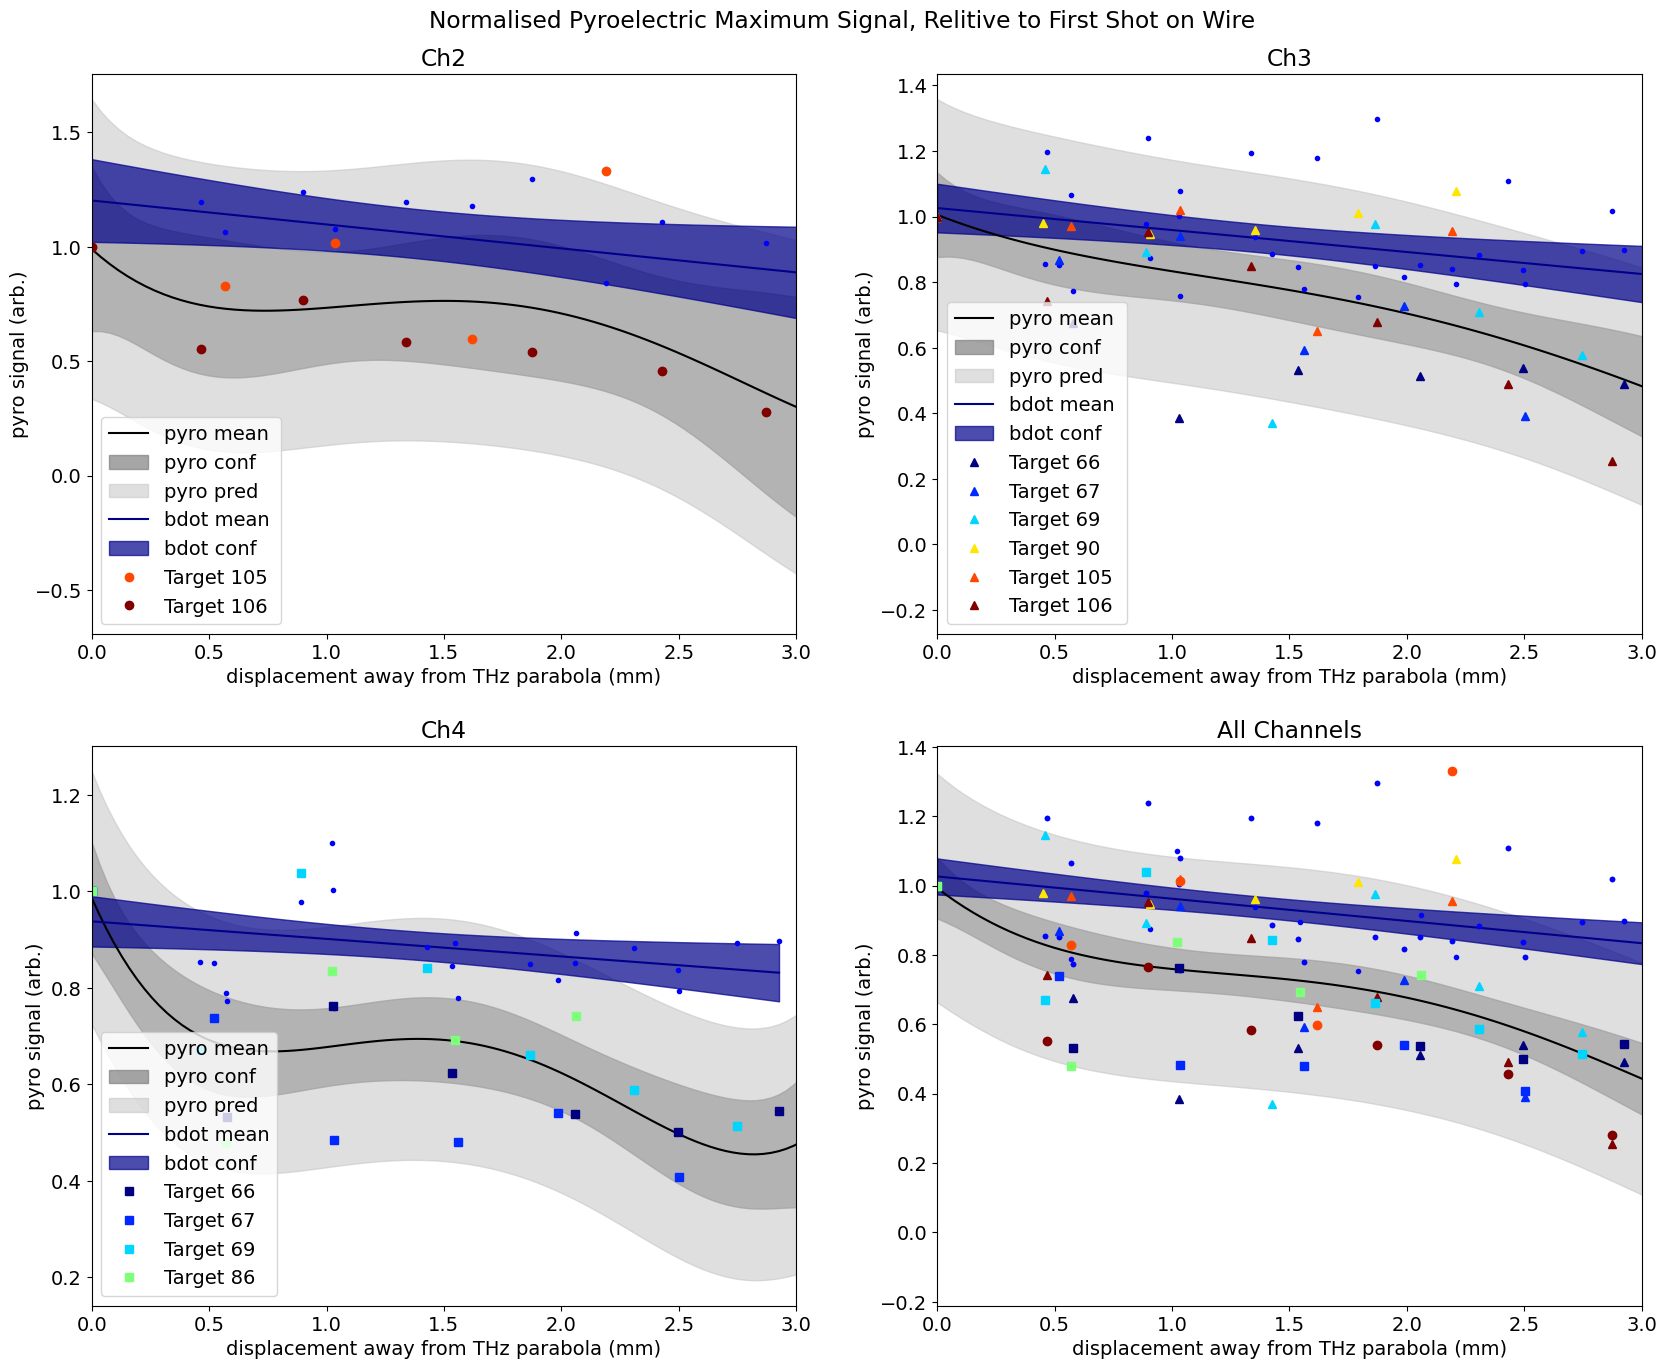

In [144]:
### Rolling Average
rolling_width = 0.35 #half width
number_of_rolling_points = 100

### Colours and markers
number_of_targets = len(dataset["TARGET NUMBER"])

colourmap = plt.get_cmap('jet')
colourvalue = np.linspace(0, 1, number_of_targets)
colours = [colourmap(value) for value in colourvalue] #openai did this bit for me.

markers = {"Ch1": "x", "Ch2": "o", "Ch3": "^", "Ch4": "s"}

### Plots
plots = [["Ch2"], ["Ch3"], ["Ch4"], list(targets.keys())] # ch2,3,4 and all three

############# VERY BIG PLOT!!##################

fig, axs = plt.subplots(2, 2, figsize= (20,16))
axs = axs.flatten()

for n, plot in enumerate(plots):
        roll_x, roll_ave, roll_delta = polynomial_fit([dataset["d"] for ch in plot],
                                                  [dataset[ch] for ch in plot],
                                                  number_of_rolling_points)

        axs[n].plot(roll_x,
                    roll_ave,
                    color= "k",
                    label= "pyro mean")
        axs[n].fill_between(roll_x,
                            roll_delta['lwr_conf'],
                            roll_delta['upr_conf'],
                            color= "gray",
                            alpha= 0.7,
                            label= "pyro conf")
        axs[n].fill_between(roll_x,
                            roll_delta['lwr_pred'],
                            roll_delta['upr_pred'],
                            color= "silver",
                            alpha= 0.5,
                            label= "pyro pred")
        bdot_x, bdot_ave, bdot_delta = polynomial_fit([dataset["d"] for ch in plot],
                                                  [[dataset["bdot"][target] if ~np.all(np.isnan(dataset[ch][target])) else np.full_like(dataset["bdot"][target], np.nan) for target in range(len(dataset["TARGET NUMBER"]))] for ch in plot],
                                                  number_of_rolling_points,
                                                  x0= [1,0])
        
        axs[n].plot(bdot_x,
                    bdot_ave,
                    color= "darkblue",
                    label= "bdot mean")
        axs[n].fill_between(bdot_x,
                            bdot_delta['lwr_conf'],
                            bdot_delta['upr_conf'],
                            color= "darkblue",
                            alpha= 0.7,
                            label= "bdot conf")
        axs[n].plot(flatten_3d_list([dataset["d"] for ch in plot]),
                    flatten_3d_list([[dataset["bdot"][target] if ~np.all(np.isnan(dataset[ch][target])) else np.full_like(dataset["bdot"][target], np.nan) for target in range(len(dataset["TARGET NUMBER"]))] for ch in plot]),
                    color= "blue",
                    linestyle= "None",
                    marker= ".")

        [axs[n].plot(dataset["d"][dataset["TARGET NUMBER"].index(target)],
                     dataset[ch][dataset["TARGET NUMBER"].index(target)],
                     color= colours[dataset["TARGET NUMBER"].index(target)],
                     label= "Target {0:d} ".format(int(target)),
                     marker = markers[ch],
                     linestyle= "None")
                     for ch in plot
                     for t, target in enumerate(targets[ch])]
                
        axs[n].set(xlabel= "displacement away from THz parabola (mm)",
                   ylabel= "pyro signal (arb.)",
                   xlim= (0, 3),
                   #ylim= (-0.1, 1.4),
                   title= plot[0] if n != 3 else "All Channels")
        if n != 3: axs[n].legend(loc= "lower left") #The legend becomes way too big on the last plot so it should be excluded.

fig.suptitle("Normalised Pyroelectric Maximum Signal, Relitive to First Shot on Wire", y= 0.92)

plt.show()

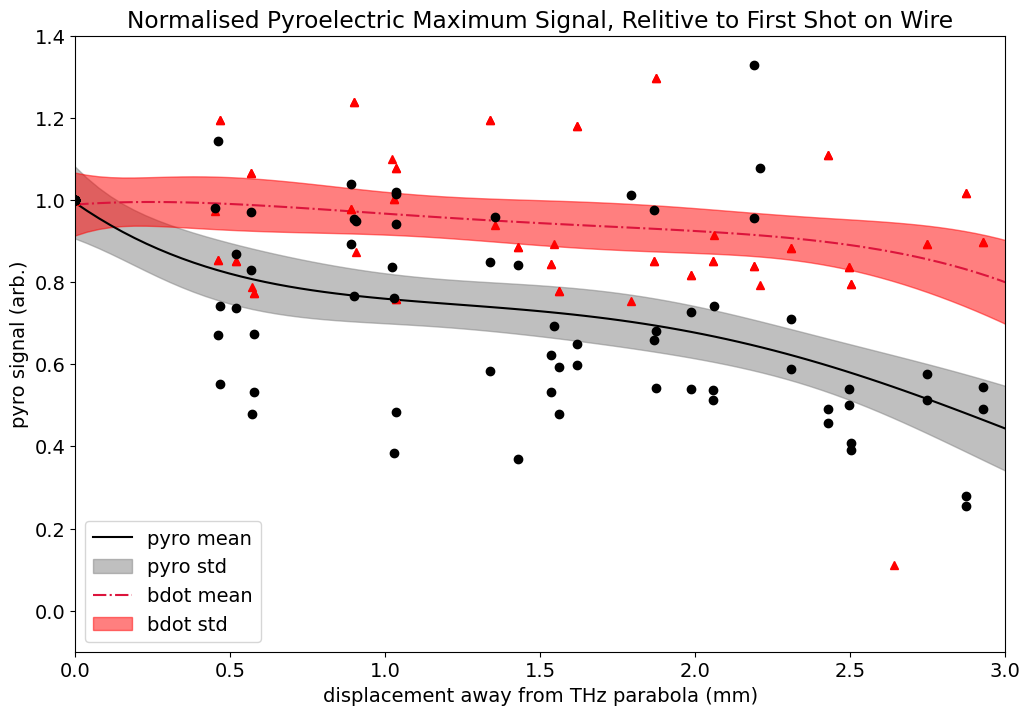

In [131]:
plot = ["Ch2","Ch3","Ch4"]

######### SIGHTLY SMALLER BUT STILL PRETTY BIG PLOT!!! #########

fig, axs = plt.subplots(1, 1, figsize= (12,8))


roll_x, roll_ave, roll_delta = polynomial_fit([dataset["d"] for ch in plot],
                                            [dataset[ch] for ch in plot],
                                            number_of_rolling_points)
axs.plot(roll_x,
        roll_ave,
        color= "k",
        label= "pyro mean")
axs.fill_between(roll_x,
                roll_delta['lwr_conf'],
                roll_delta['upr_conf'],
                color= "gray",
                alpha= 0.5,
                label= "pyro std")

bdot_x, bdot_ave, bdot_delta = polynomial_fit([dataset["d"] for ch in plot],
                                                  [[dataset["bdot"][target] if ~np.all(np.isnan(dataset[ch][target])) else np.full_like(dataset["bdot"][target], np.nan) for target in range(len(dataset["TARGET NUMBER"]))] for ch in plot],
                                                  number_of_rolling_points)
axs.plot(bdot_x,
            bdot_ave,
            color= "crimson",
            linestyle= "-.",
            label= "bdot mean")
axs.fill_between(bdot_x,
                    bdot_delta['lwr_conf'],
                    bdot_delta['upr_conf'],
                    color= "red",
                    alpha= 0.5,
                    label= "bdot std")
axs.plot(flatten_3d_list([dataset["d"] for ch in plot]),
        flatten_3d_list([[dataset["bdot"][target] if ~np.all(np.isnan(dataset[ch][target])) else np.full_like(dataset["bdot"][target], np.nan) for target in range(len(dataset["TARGET NUMBER"]))] for ch in plot]),
        color= "red",
        linestyle= "None",
        marker= "^")

[axs.plot(dataset["d"][dataset["TARGET NUMBER"].index(target)],
        dataset[ch][dataset["TARGET NUMBER"].index(target)],
        color= "k",
        marker = "o",
        linestyle= "None")
        for ch in plot
        for t, target in enumerate(targets[ch])]
        
axs.set(xlabel= "displacement away from THz parabola (mm)",
        ylabel= "pyro signal (arb.)",
        xlim= (0, 3),
        ylim= (-0.1, 1.4),
        title= plot[0] if n != 3 else "All Channels")

axs.legend(loc= "lower left")

axs.set_title("Normalised Pyroelectric Maximum Signal, Relitive to First Shot on Wire")

plt.show()